In [94]:
import numpy as np
import matplotlib
import pandas as pd
import time
import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

In [95]:
matplotlib.rcParams['figure.figsize']=(7,7)

In [202]:
dat = pd.read_csv('/Users/tony/Desktop/CigarettesSW.csv')
del dat['Unnamed: 0']
dat['sales_tax'] = (dat.taxs - dat.tax)/dat.cpi
dat['year_1995'] = 1*(dat.year == 1995)
dat['rprice'] = dat.price/dat.cpi
dat['income_pop'] = dat.income/dat.population
dat.head()

,state,year,cpi,population,packs,income,tax,price,taxs,sales_tax,year_1995,rprice,income_pop
0,AL,1985,1.076,3973000.0,116.486282,46014968,32.500004,102.181671,33.348335,0.788412,0,94.964381,11.581920
1,AR,1985,1.076,2327000.0,128.534592,26210736,37.000000,101.474998,37.000000,0.000000,0,94.307622,11.263746
2,AZ,1985,1.076,3184000.0,104.522614,43956936,31.000000,108.578751,36.170418,4.805221,0,100.909622,13.805570
3,CA,1985,1.076,26444000.0,100.363037,447102816,26.000000,107.837341,32.104000,5.672863,0,100.220580,16.907534
4,CO,1985,1.076,3209000.0,112.963539,49466672,31.000000,94.266663,31.000000,0.000000,0,87.608425,15.414980


In [203]:
# Описательные статистики
dat.describe()

,year,cpi,population,packs,income,tax,price,taxs,sales_tax,year_1995,rprice,income_pop
count,96.000000,96.000000,9.600000e+01,96.000000,9.600000e+01,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1990.000000,1.300000,5.168866e+06,109.182424,9.987874e+07,42.684028,143.447938,48.326150,4.126912,0.500000,108.284081,18.164762
std,5.026247,0.225176,5.442345e+06,25.871305,1.205411e+08,16.138088,43.887444,19.332215,2.934346,0.502625,17.364136,5.038722
min,1985.000000,1.076000,4.784470e+05,49.272198,6.887097e+06,18.000000,84.967995,21.268000,0.000000,0.000000,78.966540,9.922154
25%,1985.000000,1.076000,1.622606e+06,92.450159,2.552038e+07,31.000000,102.706415,34.770125,0.812811,0.000000,95.452061,13.834615
50%,1990.000000,1.300000,3.697472e+06,110.160660,6.166164e+07,37.000002,137.720383,41.048750,4.790106,0.500000,103.543779,17.781999
75%,1995.000000,1.524000,5.901500e+06,123.523010,1.273140e+08,50.875000,176.150471,59.476979,5.968079,1.000000,118.091999,21.976914
max,1995.000000,1.524000,3.149352e+07,197.993988,7.714701e+08,99.000000,240.849670,112.633003,10.264219,1.000000,158.037849,31.946634


In [204]:
# Среднее значение по штатам по времени
dat.groupby(['state', 'year']).mean()

cpi  population       packs     income        tax       price  \
state year                                                                    
AL    1985  1.076   3973000.0  116.486282   46014968  32.500004  102.181671   
      1995  1.524   4262731.0  101.085434   83903280  40.500004  158.371338   
AR    1985  1.076   2327000.0  128.534592   26210736  37.000000  101.474998   
      1995  1.524   2480121.0  111.042969   45995496  55.500000  175.542511   
AZ    1985  1.076   3184000.0  104.522614   43956936  31.000000  108.578751   
      1995  1.524   4306908.0   71.954170   88870496  65.333328  198.607498   
CA    1985  1.076  26444000.0  100.363037  447102816  26.000000  107.837341   
      1995  1.524  31493524.0   56.859306  771470144  61.000000  210.504669   
CO    1985  1.076   3209000.0  112.963539   49466672  31.000000   94.266663   
      1995  1.524   3738061.0   82.582924   92946544  44.000000  167.350006   
CT    1985  1.076   3201000.0  109.278351   60063368  42.000000  128.024994   
      1995  1.524   3265293.0   79.472191  104315120  74.000000  218.280502   
DE    1985  1.076    618000.0  143.851135    9927301  30.000000  102.491661   
      1995  1.524    718265.0  124.466599   18237436  48.000000  165.600006   
FL    1985  1.076  11352000.0  122.181122  166919248  37.000000  115.290001   
      1995  1.524  14185403.0   93.074554  333525344  57.900002  187.717178   
GA    1985  1.076   5963000.0  127.234619   78364336  28.000000   97.025169   
      1995  1.524   7188538.0   97.474625  159800448  36.000000  156.573074   
IA    1985  1.076   2830000.0  113.745583   37902896  34.000000  101.842003   
      1995  1.524   2840860.0   92.401596   60170928  60.000000  190.889999   
ID    1985  1.076    994000.0  103.018112   11577261  25.100000  102.899330   
      1995  1.524   1165000.0   74.849785   22868920  52.000000  179.637512   
IL    1985  1.076  11401000.0  123.208481  176786352  28.000006  104.440254   
      1995  1.524  11884935.0   83.265076  304767456  68.000008  198.476166   
IN    1985  1.076   5460000.0  137.637375   71751616  26.500000   96.180000   
      1995  1.524   5791819.0  134.258347  126525008  39.500000  154.533752   
KS    1985  1.076   2428000.0  116.680397   34784360  32.000000   98.922913   
      1995  1.524   2586942.0   88.753441   56626672  48.000000  175.210007   
KY    1985  1.076   3695000.0  186.035187   42703144  19.000000   87.001251   
      1995  1.524   3855248.0  172.647781   74079712  27.000000  145.979675   
...           ...         ...         ...        ...        ...         ...   
OK    1985  1.076   3272000.0  127.139366   43395580  34.000000  101.468079   
      1995  1.524   3265547.0  108.680107   63333300  47.000000  170.134995   
OR    1985  1.076   2673000.0  119.453796   36205164  35.000000   97.033333   
      1995  1.524   3141421.0   92.155746   71209312  62.000000  190.300003   
PA    1985  1.076  11772000.0  117.703026  170033840  34.000000  109.074005   
      1995  1.524  12044780.0   95.643089  285923232  55.000000  176.163162   
RI    1985  1.076    967000.0  132.781784   14229156  39.000000  100.941666   
      1995  1.524    989203.0   92.599800   23786644  80.000000  224.459244   
SC    1985  1.076   3304000.0  127.209442   38536176  23.000000   90.641251   
      1995  1.524   3699943.0  108.082748   72050072  31.000000  152.818741   
SD    1985  1.076    698000.0  106.590256    8340000  31.000000   97.083336   
      1995  1.524    728251.0   97.219231   14454129  47.000000  168.037994   
TN    1985  1.076   4716000.0  129.834595   57749668  29.000000  101.945503   
      1995  1.524   5241168.0  122.320053  114259984  37.000000  167.067001   
TX    1985  1.076  16275000.0  115.102928  231003152  35.250000  107.379997   
      1995  1.524  18679706.0   73.079308  402096768  65.000000  198.202332   
UT    1985  1.076   1643000.0   68.046257   19462380  28.000000  110.195839   
      1995  1.524   1976774.0   49.272198   37278220  50.500000 

In [205]:
# Корелляционная матрица для 1985 года
dat.ix[dat.year == 1985, dat.columns.difference(['state', 'year', 'year_1995'])].corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [206]:
# Корелляционная матрица для 1995 года
dat.ix[dat.year == 1995, dat.columns.difference(['state', 'year', 'year_1995'])].corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [207]:
# Регрессия для 1995 года
results = smf.ols('np.log(packs) ~ np.log(price)', data=dat.ix[dat.year_1995 == 1]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(packs)   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     31.41
Date:                Sat, 05 Jan 2019   Prob (F-statistic):           1.13e-06
Time:                        22:24:15   Log-Likelihood:                 12.724
No. Observations:                  48   AIC:                            -21.45
Df Residuals:                      46   BIC:                            -17.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.8500      1.126      9.632

In [208]:
# Регрессия для 1985 года
results = smf.ols('np.log(packs) ~ np.log(price)', data=dat.ix[dat.year_1995 == 0]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(packs)   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     14.89
Date:                Sat, 05 Jan 2019   Prob (F-statistic):           0.000353
Time:                        22:24:17   Log-Likelihood:                 24.526
No. Observations:                  48   AIC:                            -45.05
Df Residuals:                      46   BIC:                            -41.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         9.3573      1.184      7.905

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


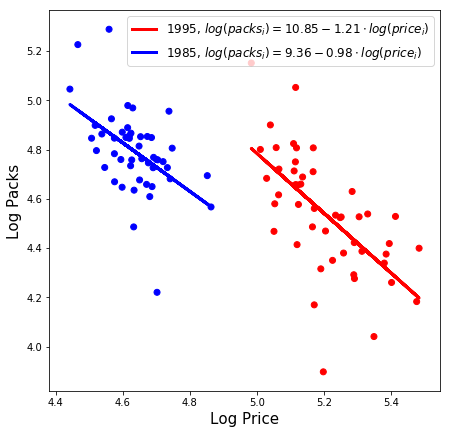

In [209]:
plt.plot(np.log(dat.price[dat.year_1995 == 1]), 10.85 - 1.2131*np.log(dat.price[dat.year_1995 == 1]), color='red', linewidth=3, label='1995, $log(packs_{i}) = 10.85 - 1.21 \cdot log(price_{i})$')
plt.plot(np.log(dat.price[dat.year_1995 == 0]), 9.3573 - 0.9848*np.log(dat.price[dat.year_1995 == 0]), color='blue', linewidth=3, label='1985, $log(packs_{i}) = 9.36 - 0.98 \cdot log(price_{i})$')
plt.xlabel(u'Log Price', fontsize=15)
plt.ylabel(u'Log Packs', fontsize=15)
plt.legend(fontsize=12)
plt.scatter(np.log(dat.price), np.log(dat.packs), color=np.array(['red', 'blue'])[dat.year == 1985]);

In [215]:
# Регрессия по методу иструментальных переменных для 1995 года
# Эндогенный регрессор - log(rprice), инструмент - sales_tax
results = IV2SLS.from_formula('np.log(packs) ~ 1 + [np.log(rprice) ~ sales_tax]', data=dat).fit()
print(results)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          np.log(packs)   R-squared:                      0.5251
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5200
No. Observations:                  96   F-statistic:                    50.699
Date:                Sat, Jan 05 2019   P-value (F-stat)                0.0000
Time:                        22:25:37   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          9.9552     0.7419     13.419     0.0000      8.5012      11.409
np.log(rprice)    -1.1322     0.1590

In [218]:
print(results.first_stage)

      First Stage Estimation Results     
                           np.log(rprice)
-----------------------------------------
R-squared                          0.4892
Partial R-squared                  0.4892
Shea's R-squared                   0.4892
Partial F-statistic                92.345
P-value (Partial F-stat)           0.0000
Partial F-stat Distn              chi2(1)
==========================     ==========
Intercept                          4.5218
                                 (236.61)
sales_tax                          0.0366
                                 (9.6096)
-----------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


In [216]:
# Тест Хаусмана говорит о том, что можно было и обычную OLS модель построить
print(results.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.0252
P-value: 0.8741
Distributed: F(1,93)


Итоговая модель спроса на сигареты:
    
$\log(\hat{packs_{i}}) = 9.96 - 1.13 \cdot \log(\hat{rprice_{i}}), \quad R^2 = 0.53$

           (0.74)(0.16)
           
$\log(\hat{price_{i}}) = 4.52 + 0.037 \cdot sales\_tax_{i}, \quad R^2 = 0.49$

          (236.61)(9.61)